In [1]:
from collections import namedtuple
from itertools import product
import black
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from astropy.stats import jackknife_resampling, jackknife_stats
from mlxtend.plotting import plot_decision_regions
from scipy.stats import bootstrap, norm, uniform
from sklearn.ensemble import BaggingRegressor, StackingClassifier
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.metrics import accuracy_score, mean_squared_error as mse
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.utils import resample
from tqdm import tqdm

In [2]:
sns.set_theme(palette='tab10')

**Содержание**<a id='toc0_'></a>    
- [__Повторные выборки (Resampling)__](#toc1_)    
  - [__Jackknife__](#toc1_1_)    
    - [__Частичная оценка параметра__](#toc1_1_1_)    
    - [__Джекнайф-оценка параметра__](#toc1_1_2_)    
    - [__Джекнайф-оценка смещения__](#toc1_1_3_)    
    - [__Пример расчета джекнайф-оценки__](#toc1_1_4_)    
    - [__Моделирование для выборок большего объема__](#toc1_1_5_)    
    - [__Джекнайф-оценка дисперсии__](#toc1_1_6_)    
  - [__Bootstrap__](#toc1_2_)    
- [__Ансамбли моделей__](#toc2_)    
  - [__Bagging (Bootstrap Aggregating)__](#toc2_1_)    
    - [__Описание алгоритма__](#toc2_1_1_)    
    - [__Бэггинг на примере задачи регрессии__](#toc2_1_2_)    
  - [__Random Forest__](#toc2_2_)    
    - [__Описание алгоритма__](#toc2_2_1_)    
  - [__AdaBoost (Adaptive Boosting)__](#toc2_3_)    
    - [__Описание алгоритма__](#toc2_3_1_)    
    - [__Пример составления ансамбля__](#toc2_3_2_)    
  - [__Stacking__](#toc2_4_)    
    - [__Описание алгоритма__](#toc2_4_1_)    
    - [__Пример составления ансамбля__](#toc2_4_2_)    
- [__Вывод разложения на смещение и разброс для MSE (Bias-variance decomposition, BVD)__](#toc3_)    
  - [__Примеры расчета оценок bias и variance__](#toc3_1_)    
    - [__BVD для случайных деревьев разной глубины__](#toc3_1_1_)    
    - [__BVD для бэггинга над решающими деревьями__](#toc3_1_2_)    

<!-- vscode-jupyter-toc-config
	numbering=false
	anchor=true
	flat=false
	minLevel=1
	maxLevel=6
	/vscode-jupyter-toc-config -->
<!-- THIS CELL WILL BE REPLACED ON TOC UPDATE. DO NOT WRITE YOUR TEXT IN THIS CELL -->

***
# <a id='toc1_'></a>[__Повторные выборки (Resampling)__](#toc0_)

Методы ресемплинга, или методы получения повторных выборок, - это статистические методы, позволяющие из данной выборки сгенерировать некоторым образом множество новых выборок. 

Методы ресемплинга это, по сути, методы моделирования поведения генеральной совокупности на основе какой-то выборки из нее. Новые выборки берутся не из генеральной совокупности, а формируются из исходной выборки, взятой из генеральной совокупности. Например, кросс-валидация один из методов ресемплинга.

Предпосылки необходимости повторных выборок:
1. Ошибочность предположения о распределении генеральной совокупности. Если предположение неверно или объем выборки мал, то параметрические методы не будут эффективны.
2. Неслучайные выборки. Классическое, "стерильное", предположение многих методов статистики - это случайность выборки. Однако бывают ситуации, когда выборка вовсе не случайна.
3. Маленький объем выборки. Для получения качественных результатов во многих статистических методах требуется, чтобы объем выборки был достаточно велик, ведь результаты асимптотические, при $n \to +\infty$.

***
## <a id='toc1_1_'></a>[__Jackknife__](#toc0_)

Предположим, что в результате эксперимента мы наблюдаем __выборку__ $X_1,X_2,\dots,X_n$ объема $n$ из генеральной совокупности $\xi$ - набор независимых в совокупности случайных величин, одинаково распределенных с $\xi$.

__Джекнайф-выборками__ $X_{[1]},X_{[2]},\dots,X_{[n]}$ называются наборы, формируемые из исходной выборки следующим образом:

$$X_{[i]} = \left(X_1,\dots,X_{i-1},X_{i+1},\dots,X_n\right),$$

то есть $i$-ая джекнайф-выборка получается из исходной удалением $i$-ого элемента. Вместо одной выборки мы получаем $n$ псевдовыборок.

***
### <a id='toc1_1_1_'></a>[__Частичная оценка параметра__](#toc0_)

Пусть $\theta$ - некоторая характеристика генеральной совокупности, а $\hat{\theta} = \hat{\theta}_n (X_1,X_2,\dots,X_n)$ - ее оценка по выборке $X_1,X_2,\dots,X_n$.

__Частичной оценкой__ $\hat{\theta}_{(-i)}, \;, i \in \{1,2,\dots,n\}$ параметра $\theta$ по джекнайф-выборке $X_{[i]}$ называется статистика
$$\hat{\theta}_{(-i)} = \hat{\theta}_{n-1}(X_{[i]}) = \hat{\theta}_{n-1} (X_1,\dots,X_{i-1},X_{i+1},\dots,X_n).$$

Вместо одной оценки интересующей характеристики по исходной выборке мы получаем $n$ частичных оценок.

__Пример__. Пусть $\theta$ - математическое ожидание генеральной совокупности. Тогда
$$\hat{\theta} = \overline{X_n} = \frac{1}{n} \sum_{i=1}^n X_i.$$

Частичная оценка $\hat{\theta}_{(-i)}, \; i \in \{1,2,\dots,n\}$ параметра $\theta$ на джекнайф-выборке $X_{[i]}$ - это статистика
$$\hat{\theta}_{(-i)} = \frac{1}{n-1} \sum_{j=1,j \ne i}^n X_j.$$

Полученная статистика - выборочное среднее $i$-ой джекнайф-выборки.

Введем обозначение для среднего арифметического частичных оценок:
$$\hat{\theta}_{(\bullet)} = \frac{1}{n} \sum_{i=1}^n \hat{\theta}_{(-i)}.$$

Величина
$$\Large \tilde{\theta}_i = n\hat{\theta}_n - (n-1)\hat{\theta}_{(-i)}, \quad i \in \{1,2,\dots,n\}$$
называется $i$-ым __псевдозначением__ параметра $\theta$, построенным по джекнайф-выборке $X_{[i]}.$

***
### <a id='toc1_1_2_'></a>[__Джекнайф-оценка параметра__](#toc0_)

__Джекнайф-оценкой__ $\hat{\theta}_{jack}$ параметра $\theta$ называется величина
$$\Large \hat{\theta}_{jack} = \frac{1}{n} \sum_{i=1}^n \tilde{\theta}_i.$$

$$\hat{\theta}_{jack} = \frac{1}{n} \sum_{i=1}^n \tilde{\theta}_i = \frac{1}{n} \sum_{i=1}^n \left(n\hat{\theta}_n - (n-1)\hat{\theta}_{(-i)}\right) =$$

$$= n\hat{\theta}_n - \frac{n-1}{n} \sum_{i=1}^n \hat{\theta}_{(-i)} = n\hat{\theta}_n - (n-1)\hat{\theta}_{(\bullet)},$$

то есть __джекнайф-оценка параметра $\theta$ - это $n$ исходных оценок на выборке $X_1,X_2,\dots,X_n$ минус $(n-1)$ среднее арифметическое частичных оценок__.

__Пример__.

In [3]:
sample = np.array([1, 4, 7, 9])
ntheta = sample.size * sample.mean()

In [4]:
masks = np.invert(np.eye(sample.size, dtype=bool))
masks

array([[False,  True,  True,  True],
       [ True, False,  True,  True],
       [ True,  True, False,  True],
       [ True,  True,  True, False]])

In [5]:
tildes = []

for mask in masks:
    tildes.append(ntheta - (sample.size - 1) * sample[mask].mean())

tildes

[1.0, 4.0, 7.0, 9.0]

In [6]:
np.mean(tildes)

5.25

In [7]:
np.mean(tildes) == sample.mean()

True

Что, разумеется, очевидно и так, поскольку псевдозначения будут совпадать с элементами исходной выборки, ведь на каждой итерации цикла из суммы всех элементов выборки вычитается сумма трех "плавающих". 

***
### <a id='toc1_1_3_'></a>[__Джекнайф-оценка смещения__](#toc0_)

Величина
$$\hat{\theta}_{jack} - \hat{\theta}_n = n\hat{\theta}_n - (n-1)\hat{\theta}_{(\bullet)} - \hat{\theta}_n = (n - 1)\left(\hat{\theta}_n - \hat{\theta}_{(\bullet)}\right),$$
которая показывает отклонение выбранной оценки от джекнайф-оценки, называется __джекнайф-оценкой смещения__ статистики $\hat{\theta}_n$.

***
### <a id='toc1_1_4_'></a>[__Пример расчета джекнайф-оценки__](#toc0_)

[__astropy.stats.jackknife_stats__](https://docs.astropy.org/en/stable/api/astropy.stats.jackknife_stats.html#jackknife-stats)

Пусть известно, что генеральная совокупность $\xi$ имеет распределение $U_{\theta,\theta + 1}$ с неизвестным параметром $\theta$. Тогда ММП-оценка $\theta$ по выборке $X_1,X_2,\dots,X_n$ это первый член построенного по выборке вариационного ряда, а частичная оценка $\hat{\theta}_{(-i)}$ - минимальный элемент $i$-ой джекнайф-выборки $X_{[i]}$.

Пусть $\theta = 2.5$, а __`sample`__ - выборка объема $10$ из равномерного распределения $U_{2.5,\,3.5}$ (значения округлены):

In [8]:
u_sample = np.array([2.60, 3.26, 2.75, 2.64, 2.83, 2.58, 3.17, 3.31, 3.48, 3.14])

In [9]:
def print_black(collection):
    print(black.format_str(repr(collection), mode=black.Mode()))

In [10]:
fields = 'estimate', 'bias', 'stderr', 'conf_interval'
JackKnifeStatsReport = namedtuple('JackKnifeStatsReport', fields)

In [11]:
jk = JackKnifeStatsReport(*jackknife_stats(u_sample, np.min))
print_black(jk)

JackKnifeStatsReport(
    estimate=2.562000000000002,
    bias=0.017999999999998018,
    stderr=0.018000000000000016,
    conf_interval=array([2.52672065, 2.59727935]),
)



In [12]:
jk.estimate + jk.bias

2.58

In [13]:
jk.estimate + jk.bias == u_sample.min()

True

Как видно, полученная джекнайф-оценка __`jk.estimate`__ оказалась ближе к истинному значению $\theta = 2.5$, чем исходная, $2.58$ (__`sample.min()`__). 

***
### <a id='toc1_1_5_'></a>[__Моделирование для выборок большего объема__](#toc0_)

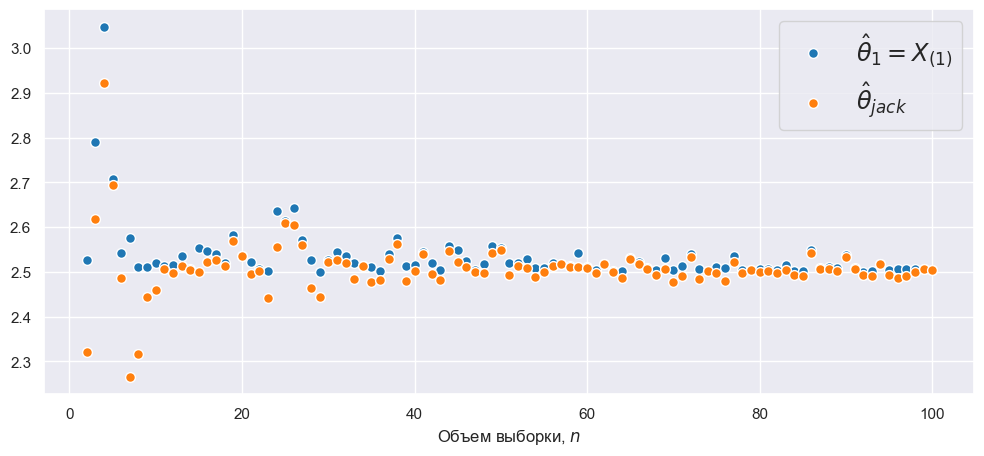

In [14]:
estimates = [], []
nrange = range(2, 101)
aes = dict(s=50, edgecolor='w')
labels = '$\\hat{\\theta}_1 = X_{(1)}$', '$\\hat{\\theta}_{jack}$'

for n in nrange:
    sample = uniform.rvs(2.5, size=n, random_state=n)
    estimates[0].append(sample.min())
    estimates[1].append(jackknife_stats(sample, np.min)[0])
    
plt.figure(figsize=(12,5))
for i, estimate in enumerate(estimates):
    plt.scatter(nrange, estimate, **aes, label=labels[i])
plt.xlabel('Объем выборки, $n$')
plt.legend(fontsize='x-large')
plt.show()

Обе оценки приближаются к истинному значению $\theta$ с ростом объема выборки $n$. Однако $\hat{\theta}_1 = X_{(1)}$ всегда оказывается больше истинного значения, равного $2.5$. Jk-оценки же располагаются по разные стороны от истинного значения и в большинстве своем находятся ближе к истинному значению:

In [15]:
[mse([2.5]*99, estimate) for estimate in estimates]

[0.005591255391936589, 0.004305730705765263]

***
### <a id='toc1_1_6_'></a>[__Джекнайф-оценка дисперсии__](#toc0_)

Оценим дисперсию $\hat{\theta}_n$. Несмещенная выборочная дисперсия псевдозначений, определяемых равенствами
$$\tilde{\theta}_i = n\hat{\theta}_n - (n-1)\hat{\theta}_{(-i)},$$
равна
$$S^2_0 (\tilde{\theta}) = \frac{1}{n-1} \sum_{i=1}^n \left(\tilde{\theta}_i - \hat{\theta}_{jack}\right)^2,$$
так как
$$\hat{\theta}_{jack} = \frac{1}{n} \sum_{i=1}^n \tilde{\theta}_i.$$

__Джекнайф-оценкой дисперсии__ $\hat{\theta}_n$ называют величину
$$\widehat{\textbf{Var}}_{jack} = \frac{S^2_0 (\tilde{\theta})}{n} = \frac{1}{n(n-1)} \sum_{i=1}^n \left(\tilde{\theta}_i - \hat{\theta}_{jack}\right)^2.$$

Если $\theta$ - математическое ожидание генеральной совокупности, а в качестве его оценки берется $\hat{\theta} = \overline{X}$, то $$\tilde{\theta}_i = X_i, \quad \hat{\theta}_{jack} = \overline{X},$$
(см. игрушечный пример выше)
а значит,
$$\widehat{\textbf{Var}}_{jack} = \frac{1}{n(n-1)} \sum_{i=1}^n \left(X_i - \overline{X}\right)^2 = \frac{\sigma^2}{n} = D_{\theta} \overline{X}.$$

$$\widehat{\textbf{Var}}_{jack} = \frac{1}{n(n-1)} \sum_{i=1}^n \left(\tilde{\theta}_i - \hat{\theta}_{jack}\right)^2 = \frac{n-1}{n} \sum_{i=1}^n \left(\hat{\theta}_{(-i)} - \hat{\theta}_{(\bullet)}\right)^2.$$

Проверка библиотечного решения:

In [16]:
resamples = jackknife_resampling(u_sample)
resamples

array([[3.26, 2.75, 2.64, 2.83, 2.58, 3.17, 3.31, 3.48, 3.14],
       [2.6 , 2.75, 2.64, 2.83, 2.58, 3.17, 3.31, 3.48, 3.14],
       [2.6 , 3.26, 2.64, 2.83, 2.58, 3.17, 3.31, 3.48, 3.14],
       [2.6 , 3.26, 2.75, 2.83, 2.58, 3.17, 3.31, 3.48, 3.14],
       [2.6 , 3.26, 2.75, 2.64, 2.58, 3.17, 3.31, 3.48, 3.14],
       [2.6 , 3.26, 2.75, 2.64, 2.83, 3.17, 3.31, 3.48, 3.14],
       [2.6 , 3.26, 2.75, 2.64, 2.83, 2.58, 3.31, 3.48, 3.14],
       [2.6 , 3.26, 2.75, 2.64, 2.83, 2.58, 3.17, 3.48, 3.14],
       [2.6 , 3.26, 2.75, 2.64, 2.83, 2.58, 3.17, 3.31, 3.14],
       [2.6 , 3.26, 2.75, 2.64, 2.83, 2.58, 3.17, 3.31, 3.48]])

In [17]:
# ddof=0, default
np.var(resamples.min(axis=1)) * (u_sample.size - 1)

0.0003240000000000006

In [18]:
jk.stderr**2

0.00032400000000000056

***
## <a id='toc1_2_'></a>[__Bootstrap__](#toc0_)

__Бутстрепом__ называют процедуру ресемплирования с повторением (_resampling with replacement_). Бутстреп это обобщенное название техники построения псевдовыборок. Статистика же, рассчитываемая по псевдовыборкам, произвольна. 

Пусть имеется выборка из произвольного неизвестного распределения и требуется хоть как-то, худо-бедно, но построить доверительный интервал для среднего. По каждой из $n=(1000\div2000)$ псевдовыборок считается среднее. Размер псевдовыборки обычно выбирается равным размеру изначальной выборки. Полученный массив из $n$ средних сортируется по неубыванию. Для построения доверительного интервала $\alpha$ отбрасываются первые и последние $\left(\frac{1-\alpha}{2} \cdot n\right)$ элементов. Либо в качестве границ доверительного интервала назначаются полусуммы порядковых статистик. Например, для $n=1000,\;\alpha=0.95$: $\frac{e_{25} + e_{26}}{2}$ и $\frac{e_{975} + e_{976}}{2}$. Истинное среднее рассматривается не как одно число, а как случайная величина. Полученные $1000$ чисел описывают распределение этой случайной величины. Процедура выше описывает, как построить интервал, в который эта случайная величина попадет с вероятностью $95\%$. Границы этого интервала это $0.025$-квантиль и $0.975$-квантиль распределения этой случайной величины.

[__scipy.stats.bootstrap__](https://scipy.github.io/devdocs/reference/generated/scipy.stats.bootstrap.html#scipy-stats-bootstrap)

In [19]:
print_black(bootstrap(u_sample.reshape(1,-1), np.min))

BootstrapResult(
    confidence_interval=ConfidenceInterval(low=2.58, high=2.6),
    bootstrap_distribution=array([2.58, 2.75, 2.58, ..., 2.6, 2.75, 2.58]),
    standard_error=0.03765070855116547,
)



***
# <a id='toc2_'></a>[__Ансамбли моделей__](#toc0_)

__Ансамбль моделей__ - это подход машинного обучения, в котором несколько моделей, т.н. _слабых учеников_, обучаются для решения одинаковой задачи, а затем объединяются для получения лучших результатов.

Пусть рассматривается обучение с учителем, дана обучающая выборка $x_1,x_2,\dots,x_n$ c откликами $y_1,y_2,\dots,y_n$, где $x_i \in X, \; y_i \in Y, \; i \in \{1,2,\dots,n\}$.

Если $X_1,X_2,\dots,X_p$ - числовые предикторы, то в качестве $X$ рассматривается $\R^p$, а конкретное наблюдение отождествляется с вектором $x_i = (x_{i1},x_{i2},\dots,x_{ip}) \in \R^p$.

При рассмотрении задачи классификации множество $Y$ обычно имеет вид $Y = \{1,2,\dots,M\}$, где $M$ - количество классов. При рассмотрении регрессии $Y$ часто либо совпадает с $\R$, либо является его непрерывным подмножеством.

Пусть $b(x): X \to R$ - базовый алгоритм, обучающийся на тренировочном наборе данных, $R$ - вспомогательное множество, а $C: R \to Y$ - т.н. решающее правило. __Алгоритмом, основанном на базовом алгоритме $b$ с решающим правилом__ $C$, называется отображение
$$a(x) = C(b(x)).$$
Пример, в котором базовый алгоритм $b(x)$, - алгоритм логистической регрессии:
$$a(x) = \begin{cases}1, &  b(x) \ge 0.5 \\ -1, & b(x) < 0.5\end{cases}.$$
$b(x)$ выдает число в диапазоне от $0$ до $1$, вероятность отнесения объекта к классу $+1$, то есть вспомогательное множество $R$ это $[0,1]$.

Пусть $b_i(x): X \to R$ - базовые алгоритмы, $i \in \{1,2,\dots,k\}$. Пусть, кроме того, $F: R^k \to R$ - корректирующее правило и $C: R \to Y$ - решающее правило. Тогда __ансамблем алгоритмов__ $b_1,b_2,\dots,b_k$ с корректирующим правилом $F$ и решающим правилом $C$ называется алгоритм
$$a(x) = C[F(b_1(x),b_2(x),\dots,b_k(x))].$$

__Примеры корректирующих правил__ $F$:
* Простое голосование, или усреднение (_simple voting_):
$$F(b_1(x),b_2(x),\dots,b_k(x)) = \frac{1}{k} \sum_{i=1}^k b_i(x).$$
* Взвешенное голосование (_weighted voting_):
$$F(b_1(x),b_2(x),\dots,b_k(x)) = \sum_{i=1}^k \omega_i b_i(x).$$
* Голосование большинством, или принятие моды:
$$F(a_1(x),a_2(x),\dots,a_k(x)) = \text{mode}(a_1(x),a_2(x),\dots,a_k(x)),$$
где $a_i(x), \; i \in \{1,2,\dots,k\}$ - алгоритмы, построенные на основе каких-то базовых алгоритмов и выдающие, скажем, класс.

***
## <a id='toc2_1_'></a>[__Bagging (Bootstrap Aggregating)__](#toc0_)

__Бэггинг__ - один из подходов к формированию ансамблей, основанный на независимом обучении базовых алгоритмов на различных выборках.

***
### <a id='toc2_1_1_'></a>[__Описание алгоритма__](#toc0_)

1. Пусть $X_1,X_2,\dots,X_n$ - выборка объема $n$, $b_1(x),b_2(x),\dots,b_t(x)$ - базовые алгоритмы.

2. По выборке $X_1,X_2,\dots,X_n$ создать $t$ независимых подвыборок
$$X^{(j)}_1,X^{(j)}_2,\dots,X^{(j)}_l, \quad j \in \{1,2,\dots,t\}$$
объема $l \le n$ методом бутстреп.

3. Для каждого $j \in \{1,2,\dots,t\}$ обучить базовый алгоритм $b_j(x)$ на выборке $X^{(j)}_1,X^{(j)}_2,\dots,X^{(j)}_l$.

4. Сформировать ансамбль
$$a(x) = C[F(b_1(x),b_2(x),\dots,b_t(x))].$$

Часто бэггинг используют для уменьшения дисперсии конкретного базового алгоритма $b(x) = b_1(x) = b_2(x) = \dots = b_t(x)$: обучают один и тот же алгоритм, но на разных подвыборках исходной выборки.

***
### <a id='toc2_1_2_'></a>[__Бэггинг на примере задачи регрессии__](#toc0_)

Время, проведенное в магазине, в зависимости от количества выбранных товаров:

In [20]:
x = np.array([15, 12, 18, 30, 3, 20, 14, 10, 20, 13])
y = np.array([10, 5, 12, 25, 1, 18, 11, 7, 19, 15])
x_test = np.array([[27]])

In [21]:
LinearRegression().fit(x.reshape(-1,1), y).predict(x_test).item()

22.982992465016153

[__sklearn.utils.resample__](https://scikit-learn.org/stable/modules/generated/sklearn.utils.resample.html#sklearn-utils-resample)

In [22]:
y_pred = []

for _ in range(1000):
    x_train, y_train = resample(x, y, n_samples=x.size)
    linreg = LinearRegression().fit(x_train.reshape(-1,1), y_train)
    y_pred.append(linreg.predict(x_test))
    
np.mean(y_pred)

23.16075852781158

***
## <a id='toc2_2_'></a>[__Random Forest__](#toc0_)

При рассмотрении бэггинга над решающими деревьями (см. ниже в этом ноутбуке) мы сделали предположение, что базовые алгоритмы некоррелированы, и за счет этого получили очень сильное уменьшение дисперсии у ансамбля относительно входящих в него базовых алгоритмов. Однако в реальной жизни добиться этого сложно, поскольку базовые алгоритмы учили одну и ту же зависимость на пересекающихся выборках. Однако на практике строгое выполнение некоррелированности базовых алгоритмов не обязательно. Достаточно, чтобы алгоритмы были в некоторой степени не похожи друг на друга. На этом строится развитие идеи бэггинга для решающих деревьев - случайный лес.

***
### <a id='toc2_2_1_'></a>[__Описание алгоритма__](#toc0_)

Случайный лес - это ансамбль деревьев принятия решений, основанный на бэггинге, но с одним важным дополнением - добавлением еще одной случайности - случайности по признакам. Каждое дерево в лесу обучается на случайной бутстреп-выборке и некотором наборе признаков из исходного тренировочного набора данных. Это делает деревья менее похожими между собой, а итоговую модель более устойчивой.

1. Для построения $i$-ого дерева:

$(a)$ Как в обычном бэггинге, из обучающей выборки $X$ выбирается с возвращением случайная подвыборка $X^i$ того же размера, что и $X$.

$(b)$ В процессе обучения каждого дерева __в каждой вершине__ случайно выбираются $n < N$ признаков, где $N$ - полное число признаков (метод случайных подпространств), и среди них ищется оптимальное разбиение. Такой прием позволяет управлять степенью скоррелированности базовых алгоритмов.

2. Для получения предсказания ансамбля на тестовом объекте усредняются отдельные ответы деревьев для регрессии и выбирается самый популярный класс для классификации.

__Сколько признаков надо подавать дереву для обучения?__

Ограничивая число признаков, которые используются в обучении одного дерева, мы также управляем качеством случайного леса. Чем больше признаков, тем больше корреляция между деревьями и тем меньше чувствуется эффект от ансамблирования. Чем меньше признаков, тем слабее сами деревья. Практическая рекомендация - брать корень из числа всех признаков для классификации и треть признаков для регрессии.

__Сколько должно быть деревьев в случайном лесе?__

Ниже будет показано, что увеличение числа элементарных алгоритмов в ансамбле не меняет смещения и уменьшает разброс. Так как число признаков и варианты подвыборок, на которых строятся деревья в случайном лесе, ограничены, уменьшать разброс до бесконечности не получится. Поэтому имеет смысл построить график ошибки от числа деревьев и ограничить размер леса в тот момент, когда ошибка перестанет значимо уменьшаться.

Вторым практическим ограничением на количество деревьев может быть время работы ансамбля.

***
## <a id='toc2_3_'></a>[__AdaBoost (Adaptive Boosting)__](#toc0_)

Основное отличие бустинга от бэггинга как метода построения ансамблей заключается в том, что слабые ученики (базовые алгоритмы) обучаются не независимо, а последовательно, учитывая опыт предыдущего. Так, каждый последующий ученик придает большее значение тем наблюдениям из тренировочного набора данных, на которых ошиблись предыдущие ученики.

Рассмотрим алгоритм адаптивного бустинга применительно к задаче двухклассовой классификации. Исходные данные: $Y = \{-1,1\}$, $x_1,x_2,\dots,x_n$ - выборка (тренировочные данные) объема $n$, $x_i \in X, \; i \in \{1,2,\dots,n\}$, $B$ - множество алгоритмов классификации, то есть
$$B = \{b\;|\;b: X \to \{-1,1\}\}.$$

При построении ансамбля будем рассматривать корректирующее правило взвешенного голосования:
$$a(x) = \text{sign} \left(\sum_{t=1}^T \omega_t b_t(x)\right),$$
где $b_t(x) \in B$, $\omega_t$ - веса (не обязательно нормированные), $t \in \{1,2,\dots,T\}$, $T$ - количество обученных алгоритмов.

Подбор алгоритмов классификации, так и весов перед ними будем производить итеративно, исходя из требования минимизации количества ошибок на тренировочных данных:
$$Q_T = \sum_{i=1}^n \mathsf{I} (a(x_i) \ne y_i) = \sum_{i=1}^n \mathsf{I} \left(y_i \sum_{t=1}^T \omega_t b_t(x_i) < 0\right) \to \min.$$

Минимизация $Q_T$ - задача затруднительная, поскольку функция не гладкая. Найдем "удобную" функцию $\tilde{Q}_T \ge Q_T$, минимизация которой согласуется с минимизацией $Q_T$:
$$Q_T \le \sum_{i=1}^n \exp \left(-y_i \sum_{t=1}^T \omega_t b_t(x_i)\right) = \tilde{Q}_T.$$

Перепишем $\tilde{Q}_T$ в виде
$$\tilde{Q}_T = \underbrace{\sum_{i=1}^n \exp \left(-y_i \sum_{t=1}^{T-1} \omega_t b_t(x_i)\right)}_{\Large \alpha_i} \; e^{-y_i \omega_T b_T(x_i)}$$
и нормируем коэффициенты $\alpha_i$ так, чтобы их сумма равнялась единице:
$$\alpha_i := \frac{\alpha_i}{\sum_{i=1}^n \alpha_i}, \quad i \in \{1,2,\dots,n\}.$$

Коэффициенты $\alpha_i$ не зависят от алгоритма $b_T$, а зависят только от алгоритмов $b_i$ с номерами $i < T$, а значит, могут быть найдены итерационно.

***
### <a id='toc2_3_1_'></a>[__Описание алгоритма__](#toc0_)

Запишем алгоритм для тренировочного набора данных $x_1,x_2,\dots.x_n$ объема $n$, заданного множества алгоритмов $B$ и числа используемых алгоритмов $T$:
1. Инициализировать начальные веса следующим образом:
$$\alpha_1 = \alpha_2 = \dots = \alpha_n = \frac{1}{n}.$$
2. Для всех $t \in \{1,2,\dots,T\}$:

$(a)$ Найти алгоритм $b_t$ из множества $B$, минимизирующий количество ошибок на тренировочном наборе данных с весами $\alpha_1,\alpha_2,\dots,\alpha_n$:
$$b_t = \argmin_{b \in B} \sum_{i=1}^n \alpha_i \cdot \mathsf{I} (b(x_i) \ne y_i).$$
Если таких алгоритмов несколько, выбрать любой.

$(b)$ Пусть
$$\varepsilon_t = \sum_{i=1}^n \alpha_i \cdot \mathsf{I} (b(x_i) \ne y_i)$$
\- найденное минимальное значение на алгоритме $b_t$. Положить
$$\Large \omega_t = \frac{1}{2} \ln \frac{1 - \varepsilon_t}{\varepsilon_t}.$$

$(c)$ Пересчитать $\alpha_i := \alpha_i \, e^{-y_i \omega_t b_t(x_i)}, \quad i \in \{1,2,\dots,n\}.$

$(d)$ Нормировать коэффициенты $\alpha_i$:
$$\alpha_i := \frac{\alpha_i}{\sum_{i=1}^n \alpha_i}, \quad i \in \{1,2,\dots,n\}.$$

3. Составить итоговый ансамбль в виде
$$a(x) = \text{sign} \left(\sum_{t=1}^T \omega_t b_t(x)\right).$$

***
### <a id='toc2_3_2_'></a>[__Пример составления ансамбля__](#toc0_)

Имеется выборка объема $n=12$, желтые точки соответствуют классу $+1$, зеленые - классу $-1$. Пусть базовые алгоритмы классификации способны разделять плоскость либо горизонтальными, либо вертикальными прямыми. Наша задача - скомпоновать три таких алгоритма классификации, снабдив их корректными весами.

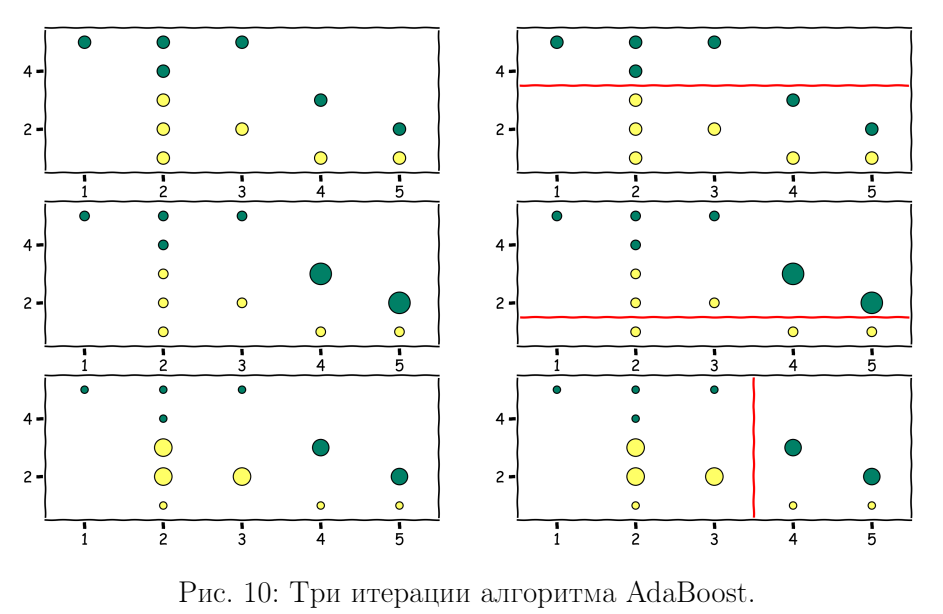

In [23]:
X = np.array([[4, 1], [2, 4], [5, 1], [3, 2], [1, 5], [3, 5],
              [2, 1], [2, 2], [2, 5], [4, 3], [2, 3], [5, 2]])

y_true = np.array([1, -1, 1, 1, -1, -1, 1, 1, -1, -1, 1, -1])

# ответы 1-ого, 2-ого и 3-его классификаторов, соответственно:
y_pred = np.array([[1, -1, 1, 1, -1, -1, 1, 1, -1, 1, 1, 1],
                   [1, -1, 1, -1, -1, -1, 1, -1, -1, -1, -1, -1],
                   [-1, 1, -1, 1, 1, 1, 1, 1, 1, -1, 1, -1]])

Инициализация коэффициентов:

In [24]:
alpha = np.array([1 / X.shape[0]] * X.shape[0])

П. $(2a)$ уже выполнен, поскольку классификаторы расположены в порядке убывания доли правильных ответов:

In [25]:
f = lambda pred: accuracy_score(y_true, pred)
np.apply_along_axis(f, axis=1, arr=y_pred)

array([0.83333333, 0.75      , 0.5       ])

In [26]:
omega = lambda eps: np.log((1 - eps) / eps) / 2

In [27]:
weights = []

for i in range(y_pred.shape[0]):
    # сумма коэффициентов, соответствующих ошибкам i-ого классификатора
    eps = alpha[y_true != y_pred[i]].sum()
    
    # расчет и логирование веса i-ого классификатора
    weights.append(weight := omega(eps))
    
    # пересчет коэффициентов
    alpha *= np.exp(-y_true * y_pred[i] * weight)
    alpha /= alpha.sum()  # нормировка
    
weights

[0.8047189562170503, 0.8673005276940532, 0.7702225204735745]

Итак, финальный алгоритм строится следующим образом:
$$a(x) = \text{sign} \left(\sum_{t=1}^3 \omega_t b_t(x)\right) \approx \text{sign} \bigl(0.805 \, b_1(x) + 0.867 \, b_2(x) + 0.770 \, b_3(x)\bigr).$$

Тогда классификация тестового объекта $(4,1)$ с помощью построенного ансамбля:
$$a(x) = \text{sign} \bigl(0.805 \cdot (+1) + 0.867 \cdot (+1) + 0.770 \cdot (-1)\bigr) = \text{sign}(0.902) = +1.$$

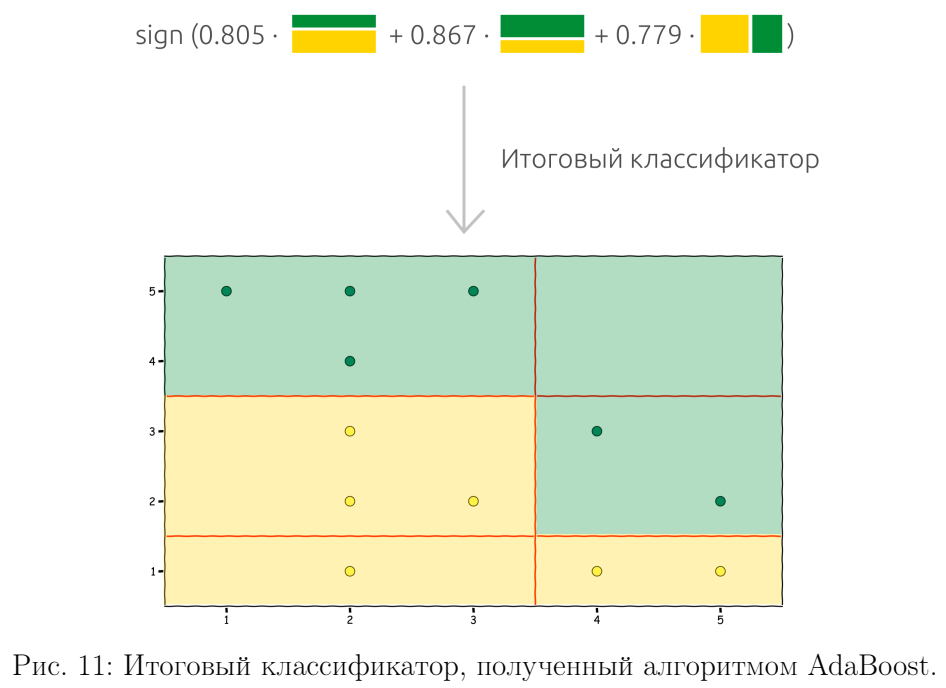

(на картинке автора накопившаяся ошибка округления)

***
## <a id='toc2_4_'></a>[__Stacking__](#toc0_)

__Стекинг__ - алгоритм ансамблирования, который может использовать базовые алгоритмы разного типа, а не только из какого-то фиксированного семейства. Результаты базовых алгоритмов объединяются в один с помощью обучаемой мета-модели, а не с помощью какого-либо обычного способа агрегации (корректирующего правила).

***
### <a id='toc2_4_1_'></a>[__Описание алгоритма__](#toc0_)

Этапы обучения стекинга:
1. Общая выборка разделяется на тренировочную и тестовую.
2. Тренировочная выборка делится на $n$ непересекающихся, почти одинаковых по размеру блоков (обычно до $10$):
$$X_{train} = X_1 \cup X_2 \cup \dots \cup X_n.$$
Фолды перебираются как при кросс-валидации: на каждом шаге фиксируются $(n-1)$ фолдов для обучения базовых алгоритмов и один - для их предсказаний: вычисления __метафакторов__, или __метапредикторов__. Такой подход нужен для того, чтобы использовать все тренировочное множество, но без переобучения базовых алгоритмов.

Для каждого $i \in \{1,2,\dots,k\}$, где $k$ - количество базовых алгоритмов, и для каждого $j \in \{1,2,\dots,n\}$ обучить базовый алгоритм $b_i$ на наборе данных
$$X_{[-j]} = X_{train} \setminus X_j$$
и протестировать на $X_j$, получив набор откликов $Y_{ji}$.

Сформировать метаданные (метапредикторы) для обучения __метамодели__:
$$X_{meta} = \begin{pmatrix}Y_{11} & Y_{12} & \dots & Y_{1k} \\
Y_{21} & Y_{22} & \dots & Y_{2k} \\
\vdots & \vdots & \ddots & \vdots \\
Y_{n1} & Y_{n2} & \dots & Y_{nk}\end{pmatrix}.$$

(Отклики базовых алгоритмов - столбцы $X_{meta}$)

3. На полученных метафакторах обучается метамодель. Помимо метафакторов она может принимать на вход предикторы из исходного датасета (см. _passthrough_ в примере ниже). Выбор зависит от решаемой задачи. В качестве откликов для обучения метамодели берутся исходные отклики $Y$.

Для получения метафакторов на тестовом множестве базовые алгоритмы обучаются на всем тренировочном множестве - переобучения возникнуть не должно.

Если данных _достаточно много_, то можно разделить обучающие данные на две непересекающиеся части: ту, на которой учатся базовые алгортимы, и ту, на которой они делают свои предсказания и обучается метамодель. Использование такого двучастного разбиения вместо кросс-валидации на тренировочных данных называют __блендингом (blending)__. Если данных _совсем много_, то тестовое множество тоже можно разделить на две части: тестовую и валидационную, и использовать последнюю для подбора гиперпараметров базовых алгоритмов.

С точки зрения смещения и разброса стекинг не имеет прямой интерпретации, так как не минимизирует напрямую ни ту, ни другую компоненту ошибки. Удачно работающий стекинг уменьшает ошибку, и, как следствие, ее компоненты тоже убывают.

***
### <a id='toc2_4_2_'></a>[__Пример составления ансамбля__](#toc0_)

Двое играют в дартс. Мишень - круг единичного радиуса с центром в $(0,0)$. С помощью стекинга составим ансамбль - модель классификации, предсказывающую исполнителя броска по координатам попадания дротика. 

In [28]:
data = np.array([[0.53, 0.77, 0], [-0.24, 0.6, 1], [-0.78, 0.46, 0],
                 [-0.9, 0.38, 0], [-0.82, -0.37, 1], [-0.43, -0.87, 0],
                 [-0.32, -0.6, 1], [-0.28, 0.04, 1], [-0.26, 0.32, 1],
                 [-0.23, 0.26, 1], [-0.02, 0.23, 1], [0.12, -0.93, 0],
                 [0.18, -0.9, 0], [0.82, 0.38, 0], [0.29, -0.04, 1],
                 [0.23, -0.57, 1], [0.57, -0.21, 0], [0.56, -0.38, 1],
                 [0.89, -0.4, 0], [0.94, -0.18, 0]])

X, y = data[:,:2], data[:,-1].astype(np.int8)

In [29]:
ticks = np.arange(-1, 1.25, 0.25)
scatter_aes = dict(s=50, c=np.where(y, 'r', 'b'))
regions_aes = dict(markers='^v', scatter_kwargs={'s': 70})

In [30]:
def plot_darts(func, *args, **kwargs):
    plt.figure(figsize=(6,6))
    func(*args, **kwargs)
    plt.xlim(-1,1)
    plt.ylim(-1,1)
    plt.xticks(ticks)
    plt.yticks(ticks)
    plt.show()

In [31]:
def num_misclassified(clf):
    return int(X.shape[0] - accuracy_score(y, clf.predict(X)) * X.shape[0])

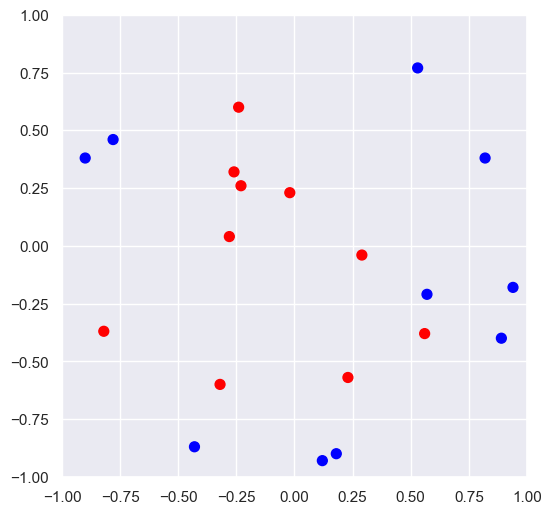

In [32]:
plot_darts(plt.scatter, *X.T, **scatter_aes)

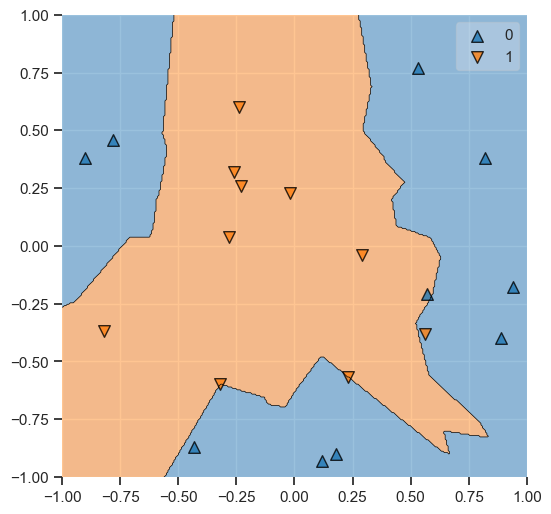

In [33]:
neigh = KNeighborsClassifier(n_neighbors=3).fit(X, y)
plot_darts(plot_decision_regions, X, y, neigh, **regions_aes)

In [34]:
num_misclassified(neigh)

4

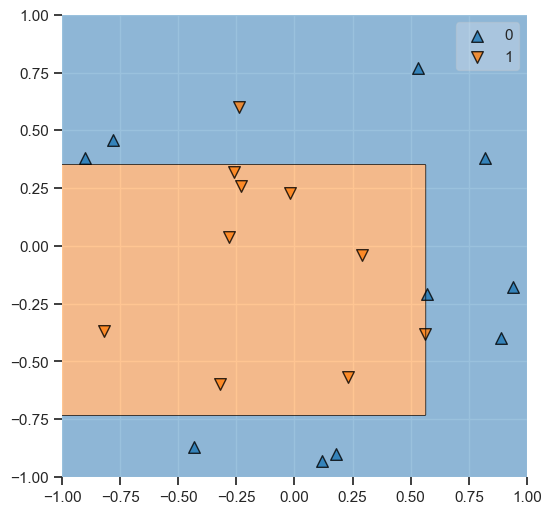

In [35]:
tree = DecisionTreeClassifier(criterion='entropy', max_depth=4).fit(X, y)
plot_darts(plot_decision_regions, X, y, tree, **regions_aes)

In [36]:
num_misclassified(tree)

1

[__sklearn.ensemble.StackingClassifier__](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.StackingClassifier.html#sklearn-ensemble-stackingclassifier)

In [37]:
estimators = [
    ('neigh', KNeighborsClassifier(n_neighbors=3)),
    ('tree', DecisionTreeClassifier(criterion='entropy', 
                                    max_depth=4,
                                    random_state=42))
]

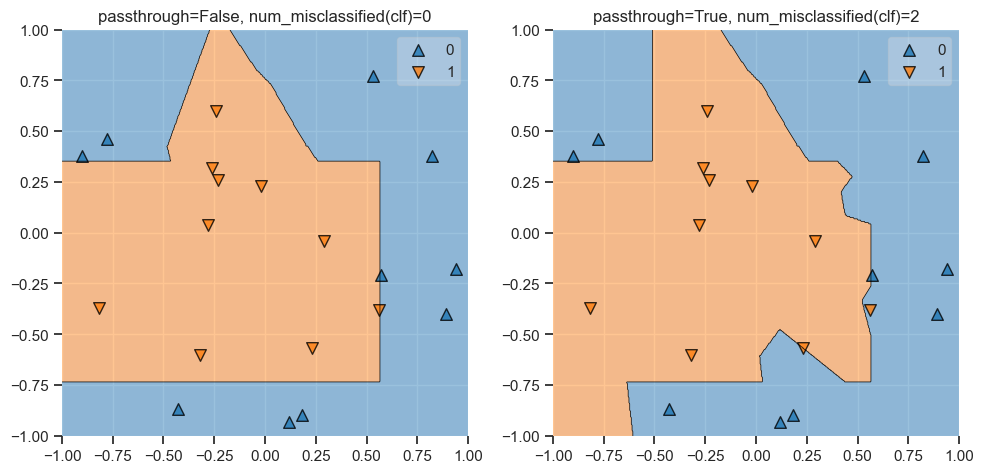

In [38]:
axs = plt.subplots(1, 2, figsize=(10,6))[1]

for i in 0, 1:
    passthrough = bool(i)
    
    clf = StackingClassifier(
        estimators=estimators, 
        final_estimator=LogisticRegression(),
        cv=2,
        passthrough=passthrough
    )
    
    clf.fit(X, y)
    
    ax = axs[i]
    plot_decision_regions(X, y, clf, **regions_aes, ax=ax)
    ax.set_xlim(-1,1)
    ax.set_ylim(-1,1)
    ax.set_xticks(ticks)
    ax.set_yticks(ticks)
    ax.set_title(f'{passthrough=}, {num_misclassified(clf)=}')
    ax.set_aspect('equal')
    
plt.tight_layout()
plt.show()

***
# <a id='toc3_'></a>[__Вывод разложения на смещение и разброс для MSE (Bias-variance decomposition, BVD)__](#toc0_)

Рассмотрим задачу регрессии с квадратичной функцией потерь. Пусть для простоты целевая переменная - одномерная и выражается через переменную $x$ как
$$y = f(x) + \varepsilon,$$
где $f$ - некоторая детерминированная функция, $\varepsilon$ - случайный шум со свойствми
$$\mathbb{E} \varepsilon = 0, \; \mathbb{D} \varepsilon = \mathbb{E} \varepsilon^2 = \sigma^2.$$

Разложение $y$ на истинную зависимость $f(x)$ и шум $\varepsilon$ может быть обусловлено:
* случайным характером данных;
* погрешностями измерений;
* недостаточностью имеющихся признаков для исчерпывающего описания объекта.

Квадартичная функция потерь на одном объекте $x$:
$$MSE = \bigl(y(x) - a(x)\bigr)^2.$$

Однако знание MSE только на одном объекте не может дать понимания, насколько хорошо работает алгоритм в общем. Какие факторы мы хотели бы учесть при оценке качества алгоритма? Например, то, что выход алгоритма на объекте зависит не только от самого этого объекта, но и от выборки $X$, на которой алгоритм обучался:
$$X = \bigl((x_1,y_1),(x_2,y_2),\dots,(x_n,y_n)\bigr), \quad a(x) = a(x,X).$$

Кроме того, значение $y$ на объекте $x$ зависит не только от $x$, но и от шума в этой точке:
$$y(x) = y(x,\varepsilon).$$

Наконец, качество измеряется на тестовых объектах $x$, которых, как правило, более одного, а значит, логично усреднять.

При включении всех вышеперечисленных источников случайности в рассмотрение логичной оценкой качества алгоритма кажется следующая величина:
$$\Large Q(a) = \mathbb{E}_x \, \mathbb{E}_{(X, \varepsilon)} \, [y(x, \varepsilon) - a(x, X)]^2.$$

Внутреннее матожидание позволяет оценить качество работы алгоритма в одной тестовой точке $x$ в зависимости от всевозможных реализаций $X$ и $\varepsilon$, а внешнее матожидание усредняет это качество по всем тестовым точкам.

Запись $\mathbb{E}_{(X, \varepsilon)}$ в общем случае обозначает взятие матожидания по совместному распределению $X$ и $\varepsilon$. Но поскольку $X$ и $\varepsilon$ независимы, $\mathbb{E}_{(X, \varepsilon)}$ равносильно последовательному взятию матожиданий по каждой из переменных: $\mathbb{E}_{(X, \varepsilon)} = \mathbb{E}_X \, \mathbb{E}_{\varepsilon}.$

Представим $Q(a)$ в более удобном для интерпретации виде. Начнем с внутреннего матлжидания:
$$\mathbb{E}_{X, \varepsilon} [y(x, \varepsilon) - a(x, X)]^2 = \mathbb{E}_{X, \varepsilon}[f(x) + \varepsilon - a(x, X)]^2 =$$

$$= \mathbb{E}_{X, \varepsilon} [ \underbrace{(f(x) - a(x, X))^2}_{\text{не зависит от $\varepsilon$}} + 
       \underbrace{2 \varepsilon \cdot (f(x) - a(x, X))}_{\text{множители независимы}} + \varepsilon^2 ] =$$

$$= \mathbb{E}_X \left[
        (f(x) - a(x, X))^2
    \right] + 2 \underbrace{\mathbb{E}_\varepsilon \varepsilon}_{0} \cdot \mathbb{E}_X (f(x) - a(x, X)) + \mathbb{E}_\varepsilon \varepsilon^2 =$$

$$= \mathbb{E}_X \left[ (f(x) - a(x, X))^2 \right] + \sigma^2.$$

Из $Q(a)$ выделилась шумовая компонента $\sigma^2.$

Продолжим преобразование первого слагаемого:

$$\mathbb{E}_X \left[ (f(x) - a(x, X))^2 \right] = \mathbb{E}_X \left[
(f(x) - \mathbb{E}_X[a(x, X)] + \mathbb{E}_X[a(x, X)] - a(x, X))^2
\right] =$$

$$= \mathbb{E}_X\underbrace{\left[ 
        (f(x) - \mathbb{E}_X[a(x, X)])^2 
    \right]}_{\text{не зависит от $X$}} + \underbrace{\mathbb{E}_X \left[ (a(x, X) - \mathbb{E}_X[a(x, X)])^2 \right]}_{\text{$\mathbb{D}_X[a(x, X)]$}} +$$

$$+ 2 \mathbb{E}_X[\underbrace{(f(x) - \mathbb{E}_X[a(x, X)])}_{\text{не зависит от $X$}} \cdot (\mathbb{E}_X[a(x, X)] - a(x, X))] =$$

$$= (\underbrace{f(x) - \mathbb{E}_X[a(x, X)]}_{\text{bias}_X a(x, X)})^2 + \mathbb{D}_X[a(x, X)] +$$

$$+ 2 (f(x) - \mathbb{E}_X[a(x, X)]) \cdot \underbrace{(\mathbb{E}_X[a(x, X)] - \mathbb{E}_X [a(x, X)])}_{0} =$$

$$= \text{bias}_X^2 a(x, X)+ \mathbb{D}_X[a(x, X)].$$

Итого:

$$Q(a) = \mathbb{E}_x \mathbb{E}_{X, \varepsilon} [y(x, \varepsilon) - a(x, X)]^2 =$$

$$=\mathbb{E}_x \text{bias}_X^2 a(x, X) + \mathbb{E}_x \mathbb{D}_X[a(x, X)] + \sigma^2,$$

где

$$\Large \text{bias}_X a(x, X) = f(x) - \mathbb{E}_X[a(x, X)]$$

\- __смещение__ предсказания алгоритма в точке $x$, усредненного по всем возможным обучающим выборкам, относительно истинной зависимости $f$;

$$\Large \mathbb{D}_X[a(x, X)] = \mathbb{E}_X \left[ a(x, X) - \mathbb{E}_X[a(x, X)] \right]^2$$

\- __дисперсия (разброс)__ предсказаний алгоритма в зависимости от обучающей выборки $X$;

$$\Large \sigma^2 = \mathbb{E}_x \mathbb{E}_\varepsilon[y(x, \varepsilon) - f(x)]^2$$

\- неустранимый __шум__ в данных.

Смещение показывает, насколько хорошо с помощью данного алгоритма можно приблизить истинную зависимость $f$, а разброс характеризует чувствительность алгоритма к изменениям в обучающей выборке. Например, деревья маленькой глубины будут в большинстве случаев иметь высокое смещение и низкий разброс предсказаний, так как они не могут слишком хорошо запомнить обучающую выборку. А глубокие деревья, наоборот, могут безошибочно выучить обучающую выборку и потому будут иметь высокий разброс в зависимости от выборки, однако их предсказания в среднем будут точнее. На рисунке ниже приведены возможные случаи сочетания смещения и разброса для разных моделей:

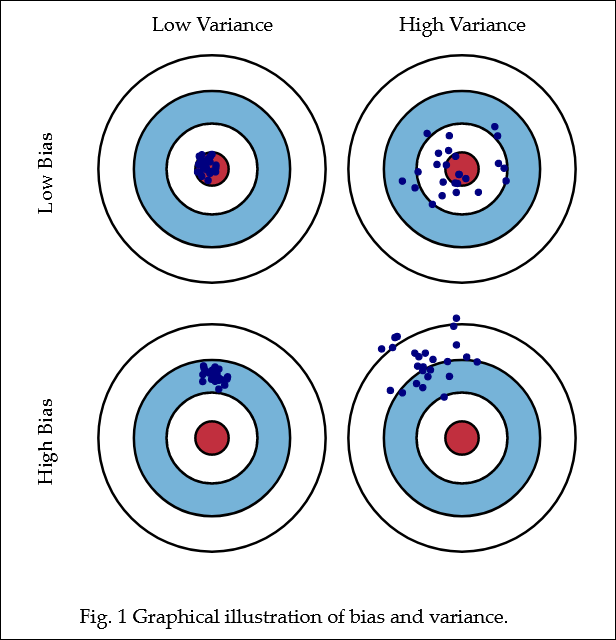

(https://scott.fortmann-roe.com/docs/BiasVariance.html)

Синяя точка соответствует модели, обученной на некоторой обучающей выборке, а всего синих точек столько, сколько было обучающих выборок. Красный круг в центре области представляет ближайшую окрестность целевого значения. Большое смещение соответствует тому, что модели в среднем не попадают в цель, а при большом разбросе модели могут как делать точные предсказания, так и довольно сильно ошибаться.

Полученное разложение ошибки на три компоненты верно только для квадратичной функции потерь. Для других функций потерь существуют более общие формы этого разложения ([__Domigos, 2000__](https://www.researchgate.net/publication/221345426_A_Unifeid_Bias-Variance_Decomposition_and_its_Applications); [__James, 2003__](http://citeseerx.ist.psu.edu/viewdoc/download;jsessionid=193A2D240404AB056822F188BAB09F94?doi=10.1.1.95.4138&rep=rep1&type=pdf)) с похожими по смыслу компонентами. Это позволяет предполагать, что для большинства основных функций потерь имеется некоторое представление в виде смещения, разброса и шума (хоть и, возможно, не в столь простой аддитивной форме).

***
## <a id='toc3_1_'></a>[__Примеры расчета оценок bias и variance__](#toc0_)

Обучающие и тестовые примеры состоят из зашумленных значений целевой функции $f(x)$. Добавляется нормальный шум с нулевым средним и большой дисперсией $\sigma^2 = 9$ для усложнения задачи для классификатора.

In [39]:
f = lambda x: x * np.sin(x)  # true func, истинная зависимость

In [40]:
def generate_data(*, n_samples=100, sigma=3, n_noise_samples=1, random_state=42):
    x = uniform.rvs(size=(n_samples, 1), random_state=random_state) * 20 - 10
    x = np.sort(x, axis=0)  # для построения графика f(x) соединением точек
    y = f(x) + norm.rvs(scale=sigma, size=(n_samples, n_noise_samples), 
                        random_state=random_state)  # f(x) + нормальный шум   
    return x, y.squeeze()

In [41]:
xticks = np.arange(-10, 10.1, 0.1)

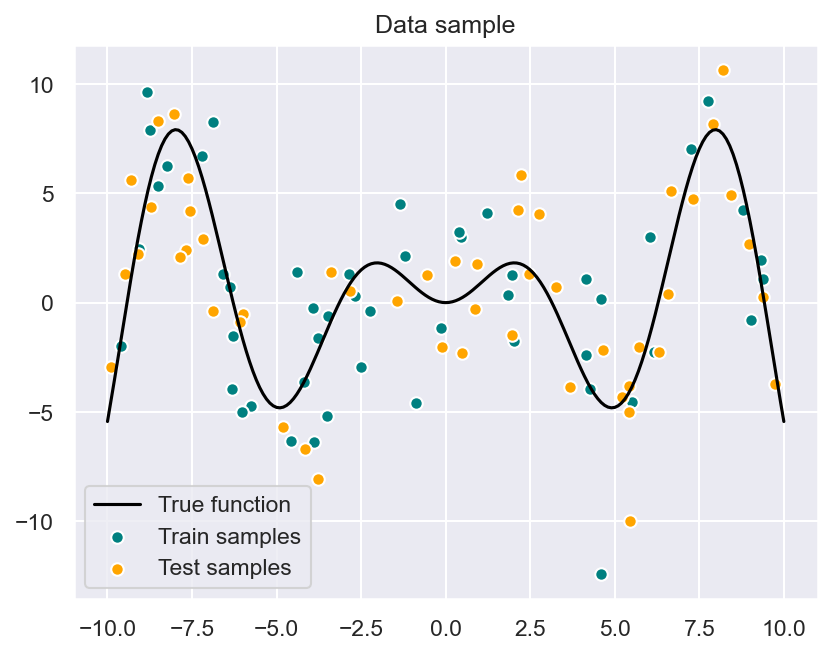

In [42]:
x, y = generate_data()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.5)

plt.figure(dpi=150)
plt.plot(xticks, f(xticks), c='k', label='True function')
plt.scatter(x_train, y_train, c='teal', ec='w', label='Train samples')
plt.scatter(x_test, y_test, c='orange', ec='w', label='Test samples')
plt.title('Data sample')
plt.legend()
plt.show()

***
### <a id='toc3_1_1_'></a>[__BVD для случайных деревьев разной глубины__](#toc0_)

Построим зависимость предсказаний деревьев от обучающих подмножеств и максимальной глубины дерева.

[__sklearn.tree.DecisionTreeRegressor__](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html#sklearn-tree-decisiontreeregressor)

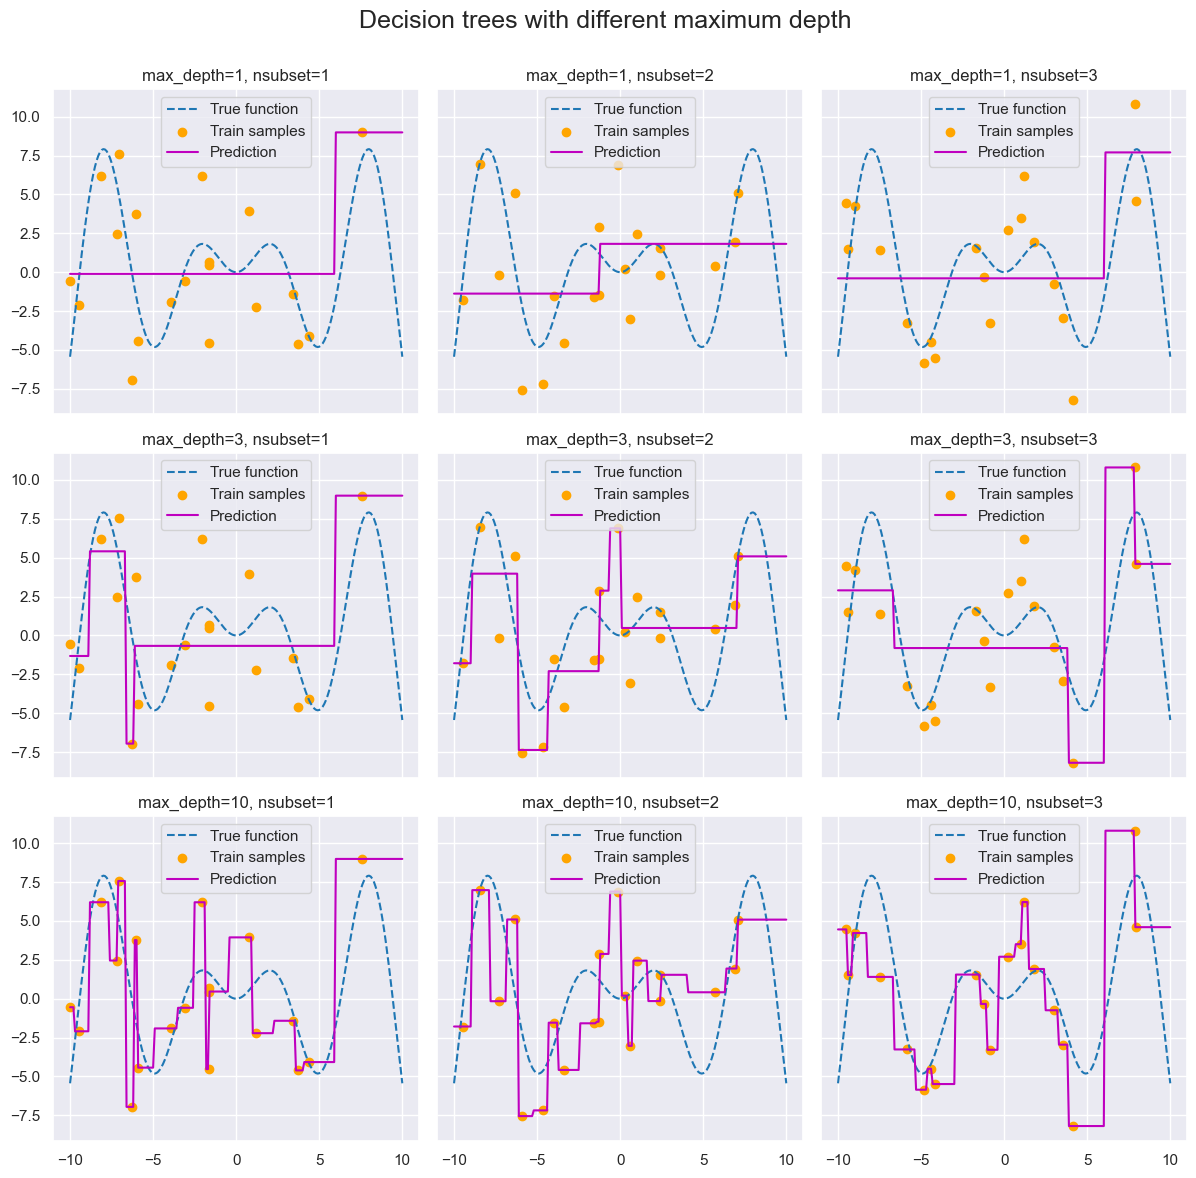

In [43]:
max_depths = 1, 3, 10
nsubsets = 3
nrows, ncols = len(max_depths), nsubsets
axs = plt.subplots(nrows, ncols, figsize=(4*ncols, 4*nrows), 
                   sharex=True, sharey=True)[1]
it = axs.flat

for max_depth, nsubset in product(max_depths, range(1, nsubsets + 1)):
    x_train, y_train = generate_data(n_samples=20, random_state=nsubset)
    clf = DecisionTreeRegressor(max_depth=max_depth).fit(x_train, y_train)
    prediction = clf.predict(xticks.reshape(-1,1))
    
    ax = next(it)
    ax.plot(xticks, f(xticks), linestyle='--', label='True function')
    ax.scatter(x_train, y_train, color='orange', label='Train samples')
    ax.plot(xticks, prediction, color='m', label='Prediction')
    ax.set_title(f'{max_depth=}, {nsubset=}')
    ax.legend(loc='upper center')
    
plt.suptitle('Decision trees with different maximum depth', fontsize=18)
plt.tight_layout(rect=(0, 0, 1, 0.98))
plt.show()

Для обучения деревьев насемплируем $1000$ случайных подмножеств $X_{train} = (x_{train},y_{train})$ размера $500$, а для тестирования зафиксируем случайное тестовое подмножество точек $x_{test}$ также размера $500$. Чтобы вычислить матожидание по $\varepsilon$, нам нужно несколько экземпляров шума $\varepsilon$ для тестовых лейблов: $y_{test} = y(x_{test}, \hat{\varepsilon}) = f(x_{test}) + \hat{\varepsilon}$. Положим количество семплов случайного шума равным $300$. Для фиксированных $X_{train} = (x_{train},y_{train})$ и $X_{test} = (x_{test},y_{test})$ квадратичная ошибка вычисляется как

$$MSE = \bigl(y_{test} - a(x_{test}, X_{train})\bigr)^2$$

Взяв среднее от $MSE$ по $X_{train}$, $x_{test}$ и $\varepsilon$, получим оценку $Q(a)$, а оценки компонент ошибки получим по выведенным выше формулам. 

In [44]:
# размеры (500,1) и (500,300), соответственно
x_test, y_test = generate_data(n_samples=500, n_noise_samples=300)

In [45]:
def get_parent_class(regressor):
    return type(regressor).__name__

In [46]:
def get_max_depth(regressor):
    parent = get_parent_class(regressor)
    if parent == 'DecisionTreeRegressor':
        return regressor.get_params()['max_depth']
    if parent == 'BaggingRegressor':
        return get_max_depth(regressor.estimator)
    raise NotImplementedError

In [47]:
def bias_variance_decomp_df(regressors, *, n_samples):
    records = []

    for regressor in regressors:
        predictions = []
        parent = get_parent_class(regressor)
        max_depth = get_max_depth(regressor)
        desc = f'{parent}, {max_depth=:02d}'
        
        for i in tqdm(range(1000), desc=desc):
            x_train, y_train = generate_data(
                n_samples=n_samples, random_state=i
            )
            regressor.fit(x_train, y_train)
            predictions.append(regressor.predict(x_test))
        
        predictions = np.stack(predictions)  # (1000,500)
        
        # все (500,)
        bias = f(x_test).squeeze() - predictions.mean(axis=0)
        variance = predictions.var(axis=0)
        noise = y_test.var(axis=1)
        
        # см. разъяснение ниже
        error = (y_test[None] - predictions[..., None])**2
        
        records.append(
            {
                'parent_class': parent,
                'max_depth': max_depth,
                'bias_sq': np.mean(bias**2),
                'variance': np.mean(variance),
                'noise': np.mean(noise),
                'error': np.mean(error),
                'Q': np.mean(bias**2 + variance + noise)
            }
        )
        
    df = pd.DataFrame.from_records(records)
    df.set_index('max_depth', inplace=True)
    return df

В __`predictions`__ $1000$ строк по $500$ предсказаний. После добавления оси в конец (__`None`__ - alias __`numpy.newaxis`__)

In [48]:
# predictions[..., None].shape
# (1000, 500, 1)

имеем $1000$ столбцов $(500,1)$, которые после согласования размерности __`y_test`__

In [49]:
# y_test[None].shape
# (1, 500, 300)

по очереди вычитаются из таблицы $(500,300)$ зашумленных семплов. Иными словами, таблица $(500,300)$ зашумленных семплов пробегает по галерее из $1000$ столбцов $(500,1)$ предсказаний (на каждом таком шаге каждый столбец таблицы вычитает из себя столбец предсказаний), образуя прямоугольный параллелепипед $(1000,500,300)$:

In [50]:
# error.shape
# (1000, 500, 300)

In [51]:
max_depths = range(1, 26)

In [52]:
regressors = [DecisionTreeRegressor(max_depth=max_depth)
              for max_depth in max_depths]

df_tree = bias_variance_decomp_df(regressors, n_samples=500)
df_tree

DecisionTreeRegressor, max_depth=25: 100%|██████████| 1000/1000 [00:01<00:00, 617.19it/s]


,parent_class,bias_sq,variance,noise,error,Q
max_depth,,,,,,
1,DecisionTreeRegressor,10.211334,1.863942,8.980058,21.060775,21.055334
2,DecisionTreeRegressor,4.963985,1.758268,8.980058,15.712074,15.702311
3,DecisionTreeRegressor,1.975215,2.117535,8.980058,13.093443,13.072808
4,DecisionTreeRegressor,0.409845,1.739371,8.980058,11.156394,11.129273
5,DecisionTreeRegressor,0.126039,1.834283,8.980058,10.970636,10.940380
6,DecisionTreeRegressor,0.035675,2.561041,8.980058,11.606163,11.576773
7,DecisionTreeRegressor,0.010777,3.497643,8.980058,12.517859,12.488478
8,DecisionTreeRegressor,0.005860,4.432635,8.980058,13.446452,13.418553
9,DecisionTreeRegressor,0.005779,5.345629,8.980058,14.359445,14.331466


In [53]:
labels = (
    r'$\mathbb{E}_x \mathrm{bias}_X^2$',
    r'$\mathbb{E}_x \mathbb{D}_X$',
    r'$\sigma^2$', r'$\mathrm{MSE}$'
)

In [54]:
def plot_bias_variance_decomp(df):
    components = df.columns[1:-1]
    values = df[components].values
    step = 2.5
    start = np.floor(values.min())
    stop = (np.ceil(values.max() / step) + 1) * step
    
    plt.figure(figsize=(9,6))
    for y, label in zip(components, labels):
        sns.lineplot(df, x=df.index, y=y, label=label)
    plt.xticks(max_depths)
    plt.yticks(np.arange(start, stop, step))
    plt.ylabel(None)
    plt.show()  

При увеличении глубины дерева смещение падает, разброс увеличивается:

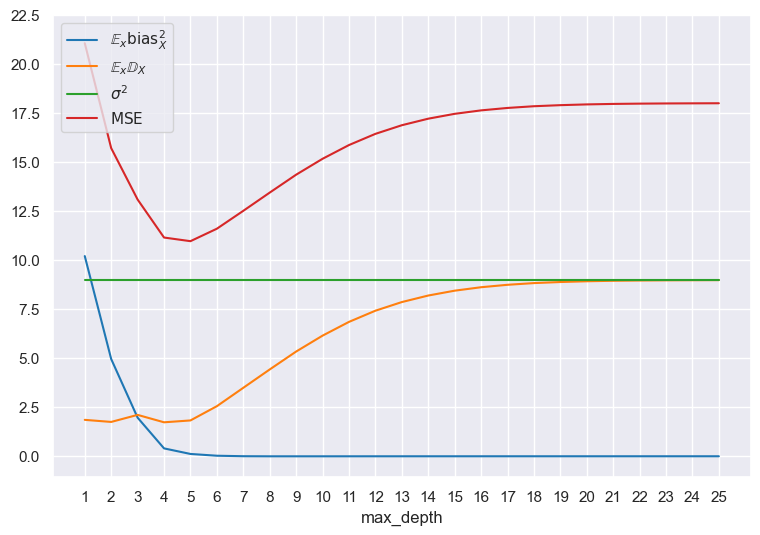

In [55]:
plot_bias_variance_decomp(df_tree)

***
### <a id='toc3_1_2_'></a>[__BVD для бэггинга над решающими деревьями__](#toc0_)

Посмотрим, как выглядят предсказания решающих деревьев глубины $7$ и бэггинга над такими деревьями в зависимости от обучающей выборки. Обучим решающие деревья $100$ раз на различных случайных семплах размера $20$. Возьмем также бэггинг над $10$ решающими деревьями глубины $7$ в качестве базовых классификаторов и тоже $100$ раз обучим его на случайных выборках размера $20$.

In [56]:
def plot_predictions(regressor, *, n_samples, title):
    predictions = []    
    for i in range(100):
        x_train, y_train = generate_data(n_samples=n_samples, random_state=i)
        regressor.fit(x_train, y_train)
        predictions.append(regressor.predict(xticks.reshape(-1,1)))
        
    plt.figure(figsize=(10,6))
    plt.plot(xticks, f(xticks), ls='--', label='True function')
    
    label = 'Predictions'
    for prediction in predictions:
        plt.plot(xticks, prediction, c='m', alpha=0.05, label=label)
        label = None
    
    mean_prediction = np.mean(np.stack(predictions), axis=0)
    plt.plot(xticks, mean_prediction, label='Mean prediction')
    
    plt.ylim(-10,10)
    plt.legend(loc='upper center')
    plt.title(title, fontsize=18)
    plt.show() 

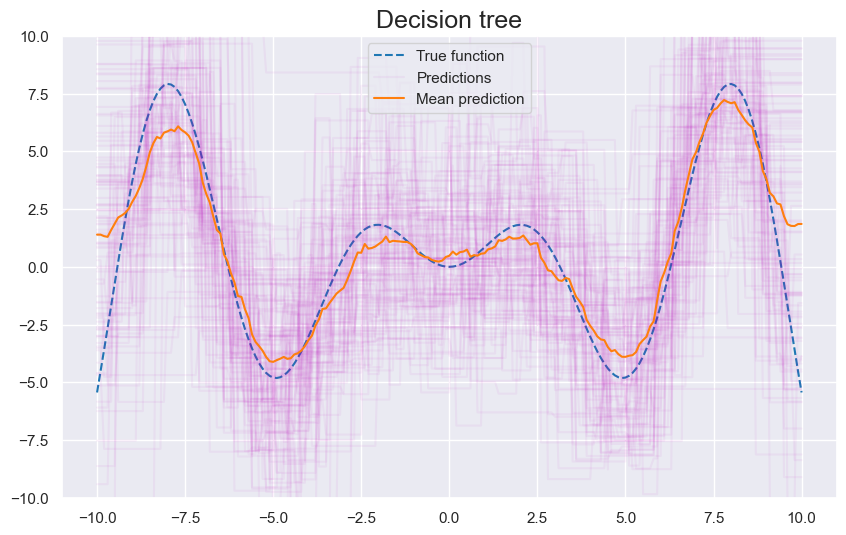

In [57]:
plot_predictions(
    DecisionTreeRegressor(max_depth=7),
    n_samples=20, 
    title='Decision tree'
)

[__sklearn.ensemble.BaggingRegressor__](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.BaggingRegressor.html#sklearn-ensemble-baggingregressor)

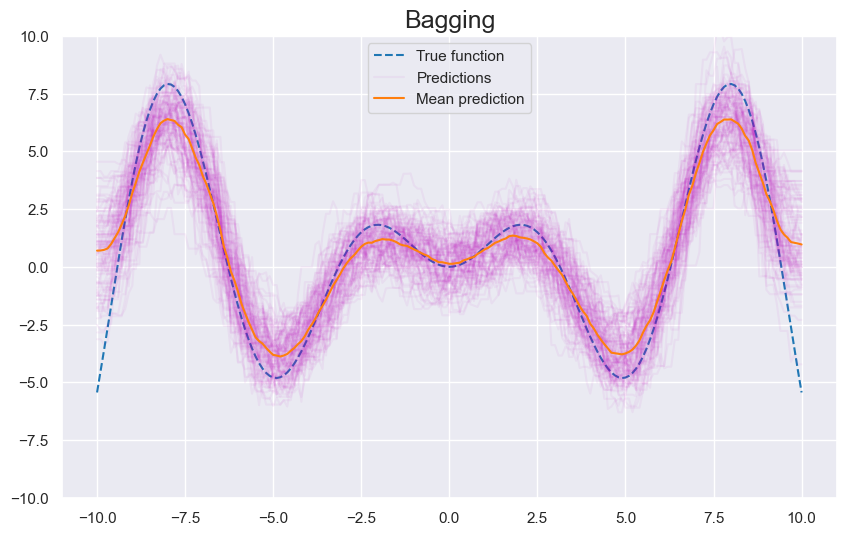

In [58]:
plot_predictions(
    BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=7),
                     n_estimators=10,
                     max_samples=20),
    n_samples=10_000, 
    title='Bagging'
)

Видно, что общая дисперсия предсказаний в зависимости от обучающего множества у бэггинга значительно ниже, чем у отдельных деревьев, а в среднем предсказания деревьев и бэггинга не отличаются.

Посмотрим, как выглядит bvd для бэггинга над деревьями в зависмости от глубины входящих в бэггинг деревьев.

In [59]:
regressors = [
    BaggingRegressor(
        estimator=DecisionTreeRegressor(max_depth=max_depth),
        n_estimators=10,
        max_samples=500
    )
    for max_depth in max_depths
]

df_bagging = bias_variance_decomp_df(regressors, n_samples=10_000)
df_bagging

BaggingRegressor, max_depth=25: 100%|██████████| 1000/1000 [00:24<00:00, 40.02it/s]


,parent_class,bias_sq,variance,noise,error,Q
max_depth,,,,,,
1,BaggingRegressor,10.185260,0.242322,8.980058,19.413313,19.407640
2,BaggingRegressor,4.952330,0.209427,8.980058,14.151429,14.141815
3,BaggingRegressor,1.963353,0.251860,8.980058,11.215807,11.195271
4,BaggingRegressor,0.411377,0.212485,8.980058,9.630728,9.603920
5,BaggingRegressor,0.123003,0.222045,8.980058,9.355414,9.325106
6,BaggingRegressor,0.031851,0.309297,8.980058,9.351225,9.321206
7,BaggingRegressor,0.008141,0.423549,8.980058,9.442039,9.411748
8,BaggingRegressor,0.002281,0.536946,8.980058,9.548343,9.519285
9,BaggingRegressor,0.001307,0.645944,8.980058,9.656195,9.627309


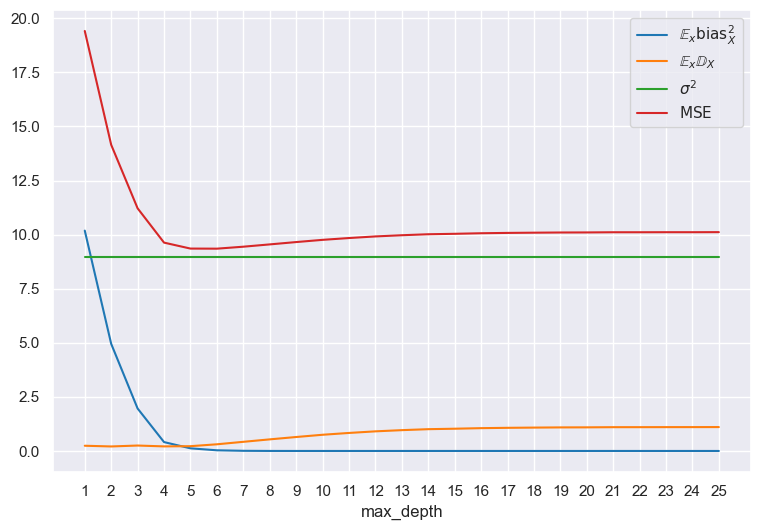

In [60]:
plot_bias_variance_decomp(df_bagging)

На графике видно, как значительно бэггинг сократил дисперсию. Чтобы подтвердить это наблюдение, изобразим смещение и разброс случайных деревьев и бэггинга в зависимости от максимальной глубины.

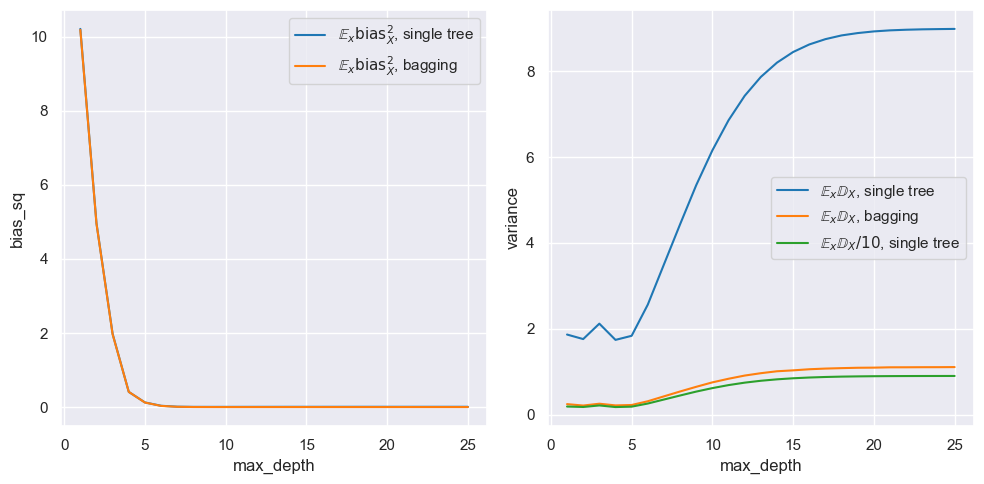

In [61]:
axs = plt.subplots(1, 2, figsize=(10,5))[1]
axs_iter = axs.flat
labels_iter = product(labels[:-1], ['single tree', 'bagging'])

for component in 'bias_sq', 'variance':
    ax = next(axs_iter)
    for df in df_tree, df_bagging:
        label = ', '.join(next(labels_iter))
        sns.lineplot(df, x=df.index, y=df[component], ax=ax, label=label)        

sns.lineplot(df_tree, x=df_tree.index, y=df_tree.variance / 10, ax=axs[1],
             label=r'$\mathbb{E}_x \mathbb{D}_X / 10$, single tree')

plt.tight_layout()
plt.show()

Дисперсия уменьшилась в $\approx 10$ раз, что равняется числу базовых алгоритмов, которые бэггинг использовал для предсказания.